In [36]:
import pandas as pd
import re
from itertools import chain
from tqdm.auto import tqdm
from transformers import pipeline
from datasets import Dataset  # HuggingFace dataset
import numpy as np
import matplotlib.pyplot as plt
import nasdaqdatalink
import os
from dotenv import load_dotenv
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY

In [37]:
combined = pd.read_csv('data/trump_truths_filtered.csv')
combined.rename(columns={'body_clean':'text', 'timestamp':'date'}, inplace=True)
combined['date'] = pd.to_datetime(combined['date'], format='%Y-%m-%d %H:%M:%S')
combined.drop(columns=['header_raw', 'market_related', 'body'], inplace=True)
combined.head()

,date,text
0,2025-05-17 10:27:00,Walmart should STOP trying to blame Tariffs as...
1,2025-05-09 08:43:00,"Many Trade Deals in the hopper, all good (GREA..."
2,2025-05-02 12:08:00,Maria Bartiromo: “As President Trump would say...
3,2025-04-30 09:13:00,"This is Biden’s Stock Market, not Trump’s. I d..."
4,2025-04-17 08:02:00,Had a very productive call with the President ...


# Don't Run this

In [38]:
# # Initialize sentiment analysis pipeline with FinBERT
# sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# # Apply sentiment analysis to the 'text' column
# # Using a loop with tqdm for progress bar, especially for larger datasets
# # For smaller datasets like this, direct application is also fine
# results = []
# for text in tqdm(combined['text'], desc="Analyzing sentiment"):
#     try:
#         result = sentiment_pipeline(text)
#         results.append(result[0]) # sentiment_pipeline returns a list of dicts
#     except Exception as e:
#         print(f"Error processing text: {text[:50]}... | Error: {e}")
#         results.append({'label': 'ERROR', 'score': np.nan}) # Handle potential errors

# # Convert results to DataFrame and merge
# sentiment_df = pd.DataFrame(results)
# combined['sentiment_label'] = sentiment_df['label']
# combined['sentiment_score'] = sentiment_df['score']

# # Display the first few rows with sentiment
# print(combined.head())

# # Display value counts for sentiment labels
# print("\nSentiment Label Counts:")
# print(combined['sentiment_label'].value_counts())

In [39]:
combined = pd.read_csv('data/finbert_sentiments.csv')

In [49]:
START_DATE = '2023-11-21'
END_DATE = '2025-05-17'
# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES',  # High Yield Corporate Bond ETF
    'IBIT': 'QUOTEMEDIA/PRICES'
}



In [50]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': START_DATE, 'lte': END_DATE},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2023-11-21 00:00:00 to 2025-05-16 00:00:00


In [51]:
price_df.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG,IBIT
date,,,,,,,,,,,,,
2023-11-21,448.604930,385.828290,174.823245,69.710864,38.584562,92.099566,86.782334,185.35,72.53,75.930125,21.18,70.580802,NaN
2023-11-22,450.336919,387.407477,175.919471,69.875826,38.506614,92.186361,87.089019,184.56,71.61,76.304307,20.97,70.703223,NaN
2023-11-24,450.614038,386.861218,177.104579,70.409525,38.526101,91.762028,86.063540,185.52,70.82,76.524979,20.76,70.627887,NaN
2023-11-27,449.802477,386.523530,176.512025,70.166935,38.370204,92.282800,87.501127,186.77,69.96,76.803216,20.55,70.731474,NaN
2023-11-28,450.247846,387.536593,175.830587,70.186342,38.691742,92.687845,87.673638,189.26,71.26,77.311720,20.86,71.042237,NaN


In [52]:
# Calculate daily percentage returns
returns_df = price_df.pct_change()

# Drop the first row of NaNs created by pct_change()
returns_df = returns_df.dropna(how='all')

print("Daily Stock Returns (first 5 rows):")
print(returns_df.head())

Daily Stock Returns (first 5 rows):
                 SPY       QQQ       IWM       EFA       EEM       AGG  \
date                                                                     
2023-11-22  0.003861  0.004093  0.006270  0.002366 -0.002020  0.000942   
2023-11-24  0.000615 -0.001410  0.006737  0.007638  0.000506 -0.004603   
2023-11-27 -0.001801 -0.000873 -0.003346 -0.003445 -0.004047  0.005675   
2023-11-28  0.000990  0.002621 -0.003861  0.000277  0.008380  0.004389   
2023-11-29 -0.000703 -0.000974  0.005280  0.002074 -0.005792  0.004890   

                 TLT       GLD       USO       VNQ       GSG       HYG  IBIT  
date                                                                          
2023-11-22  0.003534 -0.004262 -0.012684  0.004928 -0.009915  0.001734   NaN  
2023-11-24 -0.011775  0.005202 -0.011032  0.002892 -0.010014 -0.001066   NaN  
2023-11-27  0.016704  0.006738 -0.012143  0.003636 -0.010116  0.001467   NaN  
2023-11-28  0.001972  0.013332  0.018582  0.006621

In [53]:
combined['date'] = pd.to_datetime(combined['date'])

In [54]:
import numpy as np

# Prepare sentiment data
# Create a numerical sentiment score: positive_score for positive, -negative_score for negative, 0 for neutral
combined['numeric_sentiment'] = np.select(
    [combined['sentiment_label'] == 'positive', combined['sentiment_label'] == 'negative'],
    [combined['sentiment_score'], -combined['sentiment_score']],
    default=0
)

# Ensure 'date' is just the date part, without time, for daily aggregation
combined['date_only'] = combined['date'].dt.normalize()

# Aggregate sentiment by day (mean sentiment if multiple tweets)
daily_sentiment_df = combined.groupby('date_only')['numeric_sentiment'].mean().reset_index()
daily_sentiment_df = daily_sentiment_df.set_index('date_only')
daily_sentiment_df.index.name = 'date' # Match index name for merging

print("\nDaily Aggregated Sentiment (first 5 rows):")
print(daily_sentiment_df.head())


Daily Aggregated Sentiment (first 5 rows):
            numeric_sentiment
date                         
2023-11-21           0.000000
2023-11-30           0.000000
2023-12-16           0.000000
2023-12-26           0.000000
2023-12-29          -0.886635


In [55]:
# Merge stock returns with sentiment data
# We'll do a left join on returns_df to keep all trading days
merged_df = returns_df.join(daily_sentiment_df, how='left')

# Forward-fill missing sentiment values (sentiment persists until a new tweet)
merged_df['numeric_sentiment'] = merged_df['numeric_sentiment'].fillna(method='ffill')
# merged_df.dropna(inplace=True)

# Fill any remaining NaNs at the beginning (if no tweet before first trading day in range) with 0
merged_df['numeric_sentiment'] = merged_df['numeric_sentiment'].fillna(0)

print("\nMerged Data with Stock Returns and Sentiment (first 5 rows):")
print(merged_df.head())
print(f"\nShape of merged_df: {merged_df.shape}")
# Check for NaNs that might affect regression
print("\nNaNs in merged_df after processing:")
print(merged_df.isnull().sum())


Merged Data with Stock Returns and Sentiment (first 5 rows):
                 SPY       QQQ       IWM       EFA       EEM       AGG  \
date                                                                     
2023-11-22  0.003861  0.004093  0.006270  0.002366 -0.002020  0.000942   
2023-11-24  0.000615 -0.001410  0.006737  0.007638  0.000506 -0.004603   
2023-11-27 -0.001801 -0.000873 -0.003346 -0.003445 -0.004047  0.005675   
2023-11-28  0.000990  0.002621 -0.003861  0.000277  0.008380  0.004389   
2023-11-29 -0.000703 -0.000974  0.005280  0.002074 -0.005792  0.004890   

                 TLT       GLD       USO       VNQ       GSG       HYG  IBIT  \
date                                                                           
2023-11-22  0.003534 -0.004262 -0.012684  0.004928 -0.009915  0.001734   NaN   
2023-11-24 -0.011775  0.005202 -0.011032  0.002892 -0.010014 -0.001066   NaN   
2023-11-27  0.016704  0.006738 -0.012143  0.003636 -0.010116  0.001467   NaN   
2023-11-28  0.00197

C:\Users\steph\AppData\Local\Temp\ipykernel_11012\3969487347.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['numeric_sentiment'] = merged_df['numeric_sentiment'].fillna(method='ffill')


In [56]:
import statsmodels.api as sm

p_vals = []
betas = []
# Run regressions
# Iterate over each stock ticker column (excluding 'numeric_sentiment')
for ticker in returns_df.columns:
    print(f"\nRegression results for {ticker}:")
    
    # Define dependent (Y) and independent (X) variables
    Y = merged_df[ticker].copy()
    X = merged_df['numeric_sentiment'].copy()
    
    # Drop rows where Y is NaN (e.g., if a stock didn't trade on a particular day after initial processing)
    # This also handles cases where X might be NaN if ffill/fill(0) didn't cover everything, though it should.
    valid_data_idx = Y.notna() & X.notna()
    Y = Y[valid_data_idx]
    X = X[valid_data_idx]

    if len(Y) < 2 or len(X) < 2: # Not enough data points for regression
        print(f"Skipping {ticker} due to insufficient data after NaN removal (points: {len(Y)}).")
        continue
    if X.nunique() == 1: # Independent variable is constant
        print(f"Skipping {ticker} because sentiment score is constant for the available data.")
        continue

    # Add a constant for the intercept term
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(Y, X)
    results = model.fit()

    # Store p-value and beta coefficient
    p_vals.append(results.pvalues[1])  # p-value for the sentiment coefficient
    betas.append(results.params[1])  # beta coefficient for the sentiment
    
    # Print the summary
    print(results.summary())
    print("-" * 80)



Regression results for SPY:
                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.011
Date:                Tue, 20 May 2025   Prob (F-statistic):             0.0147
Time:                        14:10:15   Log-Likelihood:                 1143.3
No. Observations:                 371   AIC:                            -2283.
Df Residuals:                     369   BIC:                            -2275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const    

C:\Users\steph\AppData\Local\Temp\ipykernel_11012\2223758320.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_vals.append(results.pvalues[1])  # p-value for the sentiment coefficient
C:\Users\steph\AppData\Local\Temp\ipykernel_11012\2223758320.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(results.params[1])  # beta coefficient for the sentiment
C:\Users\steph\AppData\Local\Temp\ipykernel_11012\2223758320.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

In [58]:
# make a DataFrame for p-values and betas with ticker
p_vals_df = pd.DataFrame({
    'Ticker': returns_df.columns,
    'P-Value': p_vals,
    'Beta': betas
})
p_vals_df

,Ticker,P-Value,Beta
0,SPY,0.014684,-0.002984
1,QQQ,0.015446,-0.003769
2,IWM,0.102616,-0.002587
3,EFA,0.372123,-0.000970
4,EEM,0.282616,-0.001312
5,AGG,0.086311,0.000673
6,TLT,0.026619,0.002232
7,GLD,0.698177,0.000443
8,USO,0.023515,-0.004492
9,VNQ,0.503622,-0.000835


# GARCH

In [59]:
!pip install arch
from arch import arch_model

<Axes: xlabel='date'>

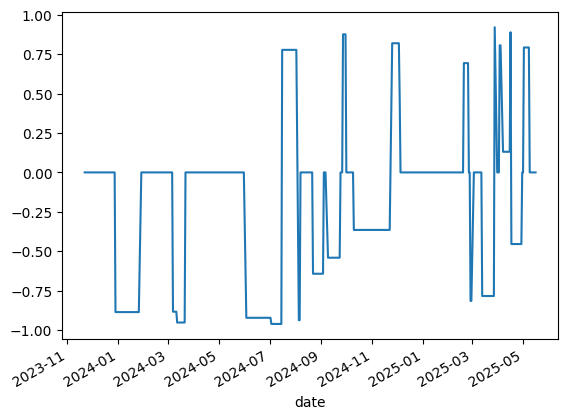

In [60]:
merged_df['numeric_sentiment'].plot()


Running GARCH(1,1) model for SPY with sentiment as exogenous variable in mean equation...
                            HAR-X - GARCH Model Results                             
Dep. Variable:                          SPY   R-squared:                       0.011
Mean Model:                           HAR-X   Adj. R-squared:                  0.008
Vol Model:                            GARCH   Log-Likelihood:               -437.508
Distribution:      Standardized Student's t   AIC:                           887.015
Method:                  Maximum Likelihood   BIC:                           909.918
                                              No. Observations:                  336
Date:                      Tue, May 20 2025   Df Residuals:                      334
Time:                              14:49:07   Df Model:                            2
                                    Mean Model                                    
                        coef    std err          t      P>|t|

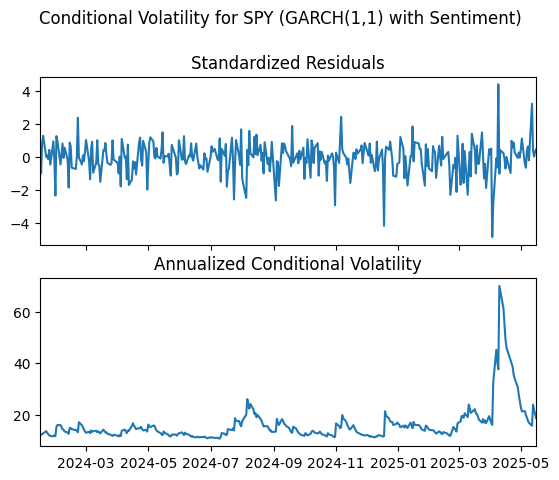

In [84]:
merged_df = merged_df.dropna()  # Ensure no NaNs for GARCH analysis
# Select a ticker for GARCH analysis, e.g., SPY
ticker_to_analyze = 'SPY'

# Prepare data for the chosen ticker
# GARCH models typically work with returns (percentage change * 100 for numerical stability)
Y_garch = merged_df[ticker_to_analyze].dropna() * 100 
X_garch = merged_df['numeric_sentiment'][Y_garch.index] # Align sentiment with available returns

# Ensure X_garch is 2D for arch_model (if it's a Series)
if isinstance(X_garch, pd.Series):
    X_garch = X_garch.to_frame()

# Check for constant sentiment again, specifically for the Y_garch.index range
if X_garch['numeric_sentiment'].nunique() == 1:
    print(f"Skipping GARCH for {ticker_to_analyze} because sentiment score is constant for the available data.")
else:
    print(f"\nRunning GARCH(1,1) model for {ticker_to_analyze} with sentiment as exogenous variable in mean equation...")
    
    # Define the GARCH(1,1) model
    # We include sentiment in the mean equation (x=X_garch)
    # p=1, q=1 for GARCH(1,1)
    # vol='Garch' specifies the GARCH volatility process
    # dist='Normal' assumes normally distributed errors, can try 't' for fatter tails
    garch_model = arch_model(Y_garch, x=X_garch, mean = "HARX", vol='Garch', p=1, q=1, dist='t')
    
    # Fit the model
    # disp='off' suppresses convergence output, can be set to 'iter' or 'final'
    garch_trump = garch_model.fit(disp='off')
    
    # Print the summary
    print(garch_trump.summary())
    
    # Plotting conditional volatility
    fig = garch_trump.plot(annualize='D') # 'D' for daily data
    plt.suptitle(f'Conditional Volatility for {ticker_to_analyze} (GARCH(1,1) with Sentiment)', y=1.02)
    plt.show()



Running GARCH(1,1) model for SPY with sentiment as exogenous variable in mean equation...
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -438.878
Distribution:      Standardized Student's t   AIC:                           887.757
Method:                  Maximum Likelihood   BIC:                           906.843
                                              No. Observations:                  336
Date:                      Tue, May 20 2025   Df Residuals:                      335
Time:                              14:49:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf.

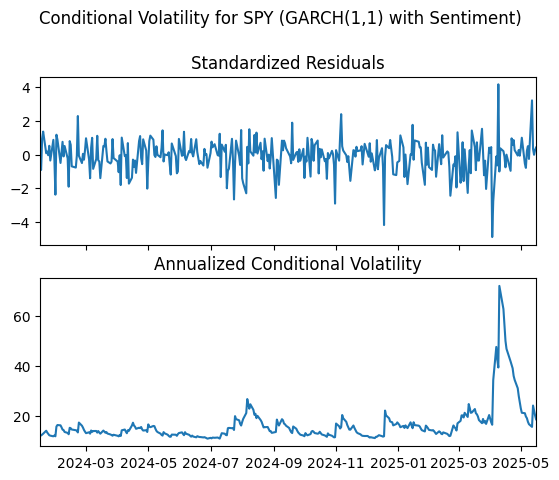

In [87]:
merged_df = merged_df.dropna()  # Ensure no NaNs for GARCH analysis
# Select a ticker for GARCH analysis, e.g., SPY
ticker_to_analyze = 'SPY'

# Prepare data for the chosen ticker
# GARCH models typically work with returns (percentage change * 100 for numerical stability)
Y_garch = merged_df[ticker_to_analyze].dropna() * 100 
X_garch = merged_df['numeric_sentiment'][Y_garch.index] # Align sentiment with available returns

# Ensure X_garch is 2D for arch_model (if it's a Series)
if isinstance(X_garch, pd.Series):
    X_garch = X_garch.to_frame()

# Check for constant sentiment again, specifically for the Y_garch.index range
if X_garch['numeric_sentiment'].nunique() == 1:
    print(f"Skipping GARCH for {ticker_to_analyze} because sentiment score is constant for the available data.")
else:
    print(f"\nRunning GARCH(1,1) model for {ticker_to_analyze} with sentiment as exogenous variable in mean equation...")
    
    # Define the GARCH(1,1) model
    # We include sentiment in the mean equation (x=X_garch)
    # p=1, q=1 for GARCH(1,1)
    # vol='Garch' specifies the GARCH volatility process
    # dist='Normal' assumes normally distributed errors, can try 't' for fatter tails
    garch_model = arch_model(Y_garch, vol='Garch', p=1, q=1, dist='t')
    
    # Fit the model
    # disp='off' suppresses convergence output, can be set to 'iter' or 'final'
    garch_results = garch_model.fit(disp='off')
    
    # Print the summary
    print(garch_results.summary())
    
    # Plotting conditional volatility
    fig = garch_results.plot(annualize='D') # 'D' for daily data
    plt.suptitle(f'Conditional Volatility for {ticker_to_analyze} (GARCH(1,1) with Sentiment)', y=1.02)
    plt.show()


In [88]:
mse_trump  = np.mean((merged_df['SPY']**2- garch_trump.conditional_volatility)**2)
mse_normal = np.mean((merged_df['SPY']**2- garch_results.conditional_volatility)**2)
print("MSE Trump Garch", mse_trump)
print("MSE Without Sentiment", mse_normal)

MSE Trump Garch 1.2834268548646388
MSE Without Sentiment 1.3210615142464504


# GRANGER CAUSALITY TEST

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import numpy as np

# Ensure merged_df is clean and suitable for time series analysis
# Drop rows with any NaN values that might remain, especially if returns data had NaNs
causality_df = merged_df.dropna()

max_lags = 5 # Define the maximum number of lags to test for Granger causality

granger_results_data = [] # Initialize list to store results for DataFrame

print(f"\nRunning Granger Causality Tests (max_lags={max_lags}):")
print("Null Hypothesis: Sentiment does NOT Granger-cause Stock Returns")
print("-" * 80)

for ticker in returns_df.columns:
    print(f"\nGranger Causality Test for {ticker} returns vs. Sentiment:")
    
    # Prepare data for the test: [dependent_variable (returns), independent_variable (sentiment)]
    test_data = causality_df[[ticker, 'numeric_sentiment']].copy()
    
    # Initialize values for the summary DataFrame for this ticker
    p_values_ssr_list = [np.nan] * max_lags
    p_values_params_list = [np.nan] * max_lags
    is_granger_caused_flag = False
    run_status = "OK" # Default status, will be updated if skipped or error

    # Check if there's enough data and variance
    if len(test_data) < max_lags + 5: # Heuristic for minimum data points
        print(f"Skipping {ticker} due to insufficient data points ({len(test_data)}).")
        run_status = f"Skipped: Insufficient data ({len(test_data)})"
    elif test_data['numeric_sentiment'].nunique() < 2:
        print(f"Skipping {ticker} because sentiment score is constant.")
        run_status = "Skipped: Sentiment constant"
    elif test_data[ticker].nunique() < 2:
        print(f"Skipping {ticker} because its returns are constant.")
        run_status = "Skipped: Returns constant"
    
    if run_status == "OK": # Proceed with the test only if not skipped
        try:
            # Perform the Granger causality test
            results = grangercausalitytests(test_data, maxlag=max_lags, verbose=False)
            
            # Process and print results in a more readable format
            print(f"Results for {ticker}:")
            significant_lags_found = False # Re-initialize for current ticker (as in original code)
            
            temp_p_ssr = []
            temp_p_params = []

            for lag in range(1, max_lags + 1):
                # Ensure results for the lag exist
                if lag in results and results[lag] and len(results[lag]) > 0:
                    ssr_ftest_result = results[lag][0].get('ssr_ftest')
                    params_ftest_result = results[lag][0].get('params_ftest')

                    p_value_ssr_ftest = ssr_ftest_result[1] if ssr_ftest_result else np.nan
                    p_value_params_ftest = params_ftest_result[1] if params_ftest_result else np.nan
                else:
                    p_value_ssr_ftest = np.nan
                    p_value_params_ftest = np.nan
                
                temp_p_ssr.append(p_value_ssr_ftest)
                temp_p_params.append(p_value_params_ftest)
                
                print(f"  Lag {lag}:")
                print(f"    F-test (SSR based) p-value: {p_value_ssr_ftest:.4f}")
                print(f"    F-test (params based) p-value: {p_value_params_ftest:.4f}")
                
                if (ssr_ftest_result and p_value_ssr_ftest < 0.05) or \
                   (params_ftest_result and p_value_params_ftest < 0.05):
                    significant_lags_found = True
            
            p_values_ssr_list = temp_p_ssr
            p_values_params_list = temp_p_params
            is_granger_caused_flag = significant_lags_found
            
            if significant_lags_found:
                print(f"  Conclusion for {ticker}: Potential Granger causality indicated at one or more lags (p < 0.05).")
            else:
                print(f"  Conclusion for {ticker}: No significant evidence of Granger causality found up to {max_lags} lags.")
                
        except Exception as e:
            print(f"Could not perform Granger causality test for {ticker}: {e}")
            run_status = f"Error: {str(e)}"
            # p_values lists remain NaNs, is_granger_caused_flag remains False
    
    # Append data for the current ticker
    granger_results_data.append({
        'Ticker': ticker,
        'P_Values_SSR_FTest': p_values_ssr_list,
        'P_Values_Params_FTest': p_values_params_list,
        'Is_Granger_Caused': is_granger_caused_flag,
        'Status': run_status
    })
    print("-" * 50)

# After the loop, create and display the summary DataFrame
granger_summary_df = pd.DataFrame(granger_results_data)
print("\nGranger Causality Test Summary:")
print(granger_summary_df)

# Save the DataFrame to a CSV file
granger_summary_df.to_csv('granger_causality_summary.csv', index=False)
print("\nSummary saved to granger_causality_summary.csv")


Running Granger Causality Tests (max_lags=5):
Null Hypothesis: Sentiment does NOT Granger-cause Stock Returns
--------------------------------------------------------------------------------

Granger Causality Test for SPY returns vs. Sentiment:
Results for SPY:
  Lag 1:
    F-test (SSR based) p-value: 0.0095
    F-test (params based) p-value: 0.0095
  Lag 2:
    F-test (SSR based) p-value: 0.0297
    F-test (params based) p-value: 0.0297
  Lag 3:
    F-test (SSR based) p-value: 0.0081
    F-test (params based) p-value: 0.0081
  Lag 4:
    F-test (SSR based) p-value: 0.0200
    F-test (params based) p-value: 0.0200
  Lag 5:
    F-test (SSR based) p-value: 0.0160
    F-test (params based) p-value: 0.0160
  Conclusion for SPY: Potential Granger causality indicated at one or more lags (p < 0.05).
--------------------------------------------------

Granger Causality Test for QQQ returns vs. Sentiment:
Results for QQQ:
  Lag 1:
    F-test (SSR based) p-value: 0.0158
    F-test (params base

/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/anaconda3/envs/q

In [30]:
granger_summary_df

,Ticker,P_Values_SSR_FTest,P_Values_Params_FTest,Is_Granger_Caused,Status
0,SPY,"[0.009469397789730443, 0.029746830221818635, 0...","[0.009469397789730577, 0.029746830221817233, 0...",True,OK
1,QQQ,"[0.015753121449946648, 0.03915276260261943, 0....","[0.015753121449946648, 0.03915276260262027, 0....",True,OK
2,IWM,"[0.01941064860626488, 0.04691623882981676, 0.0...","[0.019410648606263802, 0.04691623882981801, 0....",True,OK
3,EFA,"[0.18671069402501675, 0.16951615964589445, 0.0...","[0.18671069402501675, 0.16951615964588906, 0.0...",False,OK
4,EEM,"[0.1434437682856982, 0.13416287325163578, 0.17...","[0.143443768285711, 0.13416287325163578, 0.173...",False,OK
5,AGG,"[0.723537149127891, 0.9142528387088306, 0.9519...","[0.7235371491277186, 0.914252838708886, 0.9519...",False,OK
6,TLT,"[0.32678329593264155, 0.5000096637693492, 0.70...","[0.3267832959326519, 0.500009663769309, 0.7031...",False,OK
7,GLD,"[0.862188980111933, 0.873769564354826, 0.95168...","[0.862188980112025, 0.8737695643547729, 0.9516...",False,OK
8,USO,"[0.20927749991047487, 0.0829212288923268, 0.00...","[0.2092774999104966, 0.08292122889232915, 0.00...",True,OK
9,VNQ,"[0.17926207329179814, 0.34313556973865256, 0.2...","[0.17926207329181698, 0.3431355697386802, 0.21...",False,OK
